In [1]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization, MaxPooling2D
from librosa.core import stft
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
import tensorflow as tf
#import datagen
import soundfile as sf
import os
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression

Using TensorFlow backend.


In [2]:
num_data = 10
samp_length = 11025

X = np.zeros((5000, 65, 345))
A = np.zeros((5000, 11025))
for s in range(0, num_data):
    audio,rate = sf.read('C:/4opData/Samps/Samp' + str(s) + '.wav')
    print(audio.shape)
    if(audio.shape[0] < samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    else:
        audio = audio[0:samp_length]
    A[s] = audio
    spect = stft(audio, n_fft=128)
    print(spect.shape)
    X[s] = spect

(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)
(11025,)
(65, 345)


c:\users\joe\summer\synthavinci\env\lib\site-packages\ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


In [ ]:
Spectogram = np.abs(librosa.feature.melspectrogram(A[7], sr=44100, n_mels=512))
                                                    
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
print(Spectogram.shape)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

Load waves and output stft as numpy binary files:

In [ ]:
num_data = 200000
samp_length = 11025

for s in range(30000, num_data):
    audio,rate = sf.read('C:/4opData/Samps/Samp' + str(s) + '.wav')
    if(audio.shape[0] < samp_length):
        padded = np.zeros(shape=(samp_length))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    else:
        audio = audio[0:samp_length]

    spect = np.abs(librosa.feature.melspectrogram(audio, sr=44100, n_mels=512))
    spect = np.mean(spect, axis=1)
    #print(np.shape(spect))
    np.save('C:/Users/Joe/Summer/4opSpects/spect' + str(s) + '.stft', spect)
        

Generator to load the stft and matrix files in batches:

In [48]:
def dataLoader(batch_size):

    L = 27000
    print(L)

    #this line is just to make the generator infinite, keras needs that    
    while True:
        batch_start = 0
        batch_end = batch_size
        ymat = np.genfromtxt('C:/4opData/mat.txt', delimiter = ',', max_rows=27000)
        while batch_start < L:
            X = np.zeros((batch_size,512))
            for i in range (batch_start,batch_end):
                limit = min(batch_end, L)
                ft = np.load('C:/Users/Joe/Summer/4opSpects/spect' + str(i) + '.stft.npy')
                X[i - batch_start] = ft
            Y = ymat[batch_start:batch_end]
            X = np.expand_dims(X, axis = 3)
            X = np.expand_dims(X, axis = 3)
            
            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [37]:
num_data = 27000
samp_length = 11025

Load test data

In [51]:
test_size = 3000
Y_data = np.zeros(shape=(test_size))
mat = np.genfromtxt('C:/4opData/mat.txt', delimiter=',')
Y_test = mat[num_data:num_data+test_size]

X_test = np.zeros((test_size,512))
for i in range (num_data,num_data+test_size):
    ft = np.load('C:/Users/Joe/Summer/4opSpects/spect' + str(i) + '.stft.npy')
    X_test[i-num_data] = ft

X_test = np.expand_dims(X_test, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

c:\users\joe\summer\synthavinci\env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  # This is added back by InteractiveShellApp.init_path()


In [5]:

#def customLoss(yTrue, yPred):
#    return K.sum(K.mean(K.square(yTrue[:, 0:2] - yPred[:, 0:2]))) + K.sum(K.mean(K.square(yTrue[:, 2:4] - yPred[:, 2:4]))) * 2 + K.sum(K.mean(K.square(yTrue[:, 4] - yPred[:, 4])))

In [57]:
inputs = Input(shape=(512,1,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(64, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = Convolution2D(128, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(256, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = Convolution2D(256, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(256, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = Convolution2D(256, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Convolution2D(512, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = Convolution2D(512, kernel_size=(12, 1), strides=(1, 1), padding="same", activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Flatten()(x)
#x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
#x = Dense(512, activation='relu')(x)
x = Dense(8)(x)
# This creates a model that includes
# the Input layer and three Dense layers
adam = optimizers.Adam(lr=0.0001)
model = Model(inputs=inputs, outputs=x)
model.compile(adam,
              loss='mean_squared_error',
              metrics=['accuracy'])

In [58]:
model.fit_generator(dataLoader(27), steps_per_epoch=1000, epochs=40, verbose=1)

27000


c:\users\joe\summer\synthavinci\env\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Epoch 1/40
   5/1000 [..............................] - ETA: 8:48 - loss: 10.6111 - acc: 0.1185 

c:\users\joe\summer\synthavinci\env\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


1000/1000 [==============================] - 35s 35ms/step - loss: 0.1578 - acc: 0.2435
Epoch 2/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0618 - acc: 0.2806
Epoch 3/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0588 - acc: 0.2952
Epoch 4/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0568 - acc: 0.3034
Epoch 5/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0551 - acc: 0.3119
Epoch 6/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0538 - acc: 0.3176
Epoch 7/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0526 - acc: 0.3260
Epoch 8/40
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0514 - acc: 0.3327
Epoch 9/40
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0504 - acc: 0.3370
Epoch 10/40
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0492 - acc: 0.3440
Epoch 11/40
1000/100

In [103]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 512, 1, 1)]       0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 512, 1, 1)         4         
_________________________________________________________________
max_pooling2d_138 (MaxPoolin (None, 256, 1, 1)         0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 256, 1, 64)        256       
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 128, 1, 64)        0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 128, 1, 128)       24704     
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 64, 1, 128)        0  

In [59]:
o = model.predict(X_test)

In [60]:
model.evaluate(X_test, Y_test)

3000/3000 [==============================] - 1s 286us/sample - loss: 0.0630 - acc: 0.3140


[0.06299395408233006, 0.314]

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


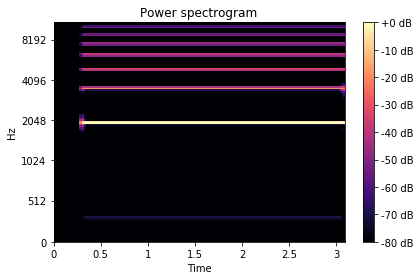

In [145]:
audio = wavload.readwav('/Users/josephcleveland/Desktop/Screech.wav')[2]
audio = audio.T[0]

X_audio = audio[0:67584].astype(float)
X_piano = np.zeros((1, 64, 64))
X_piano[0] = stft(X_audio,n_fft=1408)[0:64, 0:64]
X_piano = np.expand_dims(X_piano, axis=3)

Spectogram = np.abs(librosa.feature.melspectrogram(X_audio, sr=44100, n_mels=128))
librosa.display.specshow(librosa.amplitude_to_db(Spectogram,
                        ref=np.max),
                          y_axis='mel', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

o = model.predict(X_piano)

In [61]:
average_dist = np.zeros(8)

for p in range(0, 8):
    dist_total = 0
    for i in range(0, 3000):
        dist_total += np.absolute(o[i, p] - Y_test[i, p])
    average_dist[p] = dist_total / 3000
    
print(average_dist)
print("average: ", np.average(average_dist))

[0.05612891 0.11750871 0.13971848 0.23131591 0.19847282 0.26225086
 0.24871163 0.24980046]
average:  0.18798847183131392


In [41]:
sam = 1
print("predicted", o[sam])
print("original", Y_test[sam])

predicted [0.7553094  0.6772903  0.12203838 0.50940853 0.31881514]
original [0.819 0.724 0.121 0.499 0.278]


In [50]:
np.savetxt("C:/Users/Joe/Summer/Seymour.csv", o, delimiter=",")

In [51]:
# Save the weights
model.save_weights('C:/Users/Joe/Summer/ModelWeights/Seymour.h5')

# Save the model architecture
with open('C:/Users/Joe/Summer/ModelWeights/Seymour.json', 'w') as f:
    f.write(model.to_json())